In [1]:
import sys, importlib
# "../" to go back one director
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import os
# import torch.nn as nn
# from Modules.Utils.Imports import *
# from Modules.Utils.Gradient import Gradient
# from Modules.Utils.ModelWrapper import ModelWrapper
# from Modules.Models.BuildSurfaceFitter import *
# from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import scipy.io
from scipy import integrate, interpolate
from scipy.sparse import spdiags
from scipy import sparse
from scipy.stats import multivariate_normal
import random

random.seed(42)

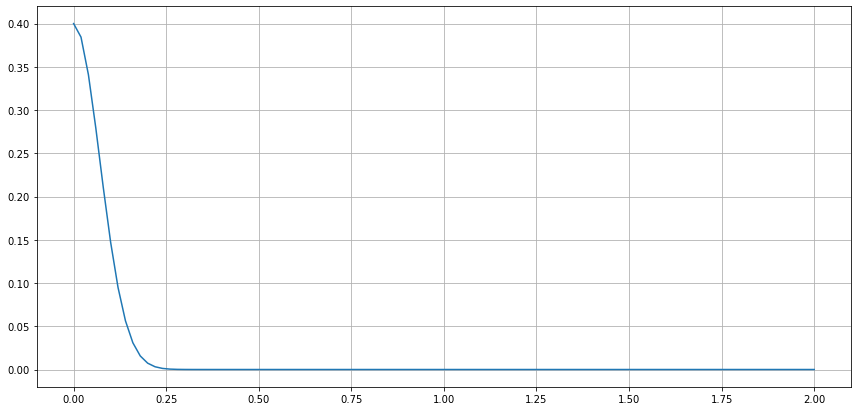

In [2]:
numX = 101
numT = 51

minX = 0
maxX = 2

minT = 0
maxT = 2

x = np.linspace(minX, maxX, numX)
t = np.linspace(minT, maxT, numT)

phi0 = 0.4*np.exp(-x**2/(0.1**2))

# plot in time
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x', 'o', 's', 'd', '^']
plt.figure(figsize=(14.6,7))
plt.plot(x, phi0, '-', c=colors[0])
plt.grid()

In [3]:
minD = 0
maxD = 0.12
dD = 0.004 #0.0024

minRho = 0.0
maxRho = 12.0
dRho = 0.2

minK = 0.02
maxK = 1.0
dK = 0.02 #0.02

In [4]:
meanD1 = 0.01
sigmaD1 = 5e-4
meanD2 = 0.1
sigmaD2 = 1e-3
meanD3 = 0.04
sigmaD3 = 5e-4

meanRho2 = 10
sigmaRho2 = 1
meanRho1 = 1
sigmaRho1 = 1
meanRho3 = 5
sigmaRho3 = 1

mean1 = [meanD1, meanRho2]
sigma1 = [[sigmaD1, 0],[0, sigmaRho2]]

mean2 = [meanD2, meanRho1]
sigma2 = [[sigmaD2, 0],[0, sigmaRho1]]

mean3 = [meanD3, meanRho3]
sigma3 = [[sigmaD3, 0],[0, sigmaRho3]]

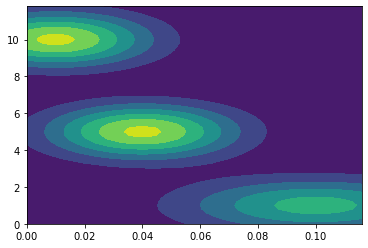

In [5]:
D_mesh, rho_mesh = np.mgrid[minD:maxD:dD, minRho:maxRho:dRho]

params_mesh = np.dstack((D_mesh, rho_mesh))

mrv1 = multivariate_normal(mean1, sigma1)
mrv2 = multivariate_normal(mean2, sigma2)
mrv3 = multivariate_normal(mean3, sigma3)

pdf_mesh1 = mrv1.pdf(params_mesh)
pdf_mesh2 = mrv2.pdf(params_mesh)
pdf_mesh3 = mrv3.pdf(params_mesh)

pdf_mesh = 1*pdf_mesh1 + 1*pdf_mesh2 + 1*pdf_mesh3
pdf_mesh = pdf_mesh/sum(sum(pdf_mesh))

# threshold = 1e-3

# pdf_mesh[pdf_mesh < threshold] = 0
pdf_mesh = pdf_mesh/sum(sum(pdf_mesh))

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contourf(D_mesh, rho_mesh, pdf_mesh)

In [6]:
total_pop = pdf_mesh.shape[0]*pdf_mesh.shape[1]
# params_vec = np.concatenate((np.reshape(D_mesh, (total_pop, -1)), np.reshape(K_mesh, (total_pop, -1))), axis=1)
D_vec = np.reshape(D_mesh, (total_pop, -1))
rho_vec = np.reshape(rho_mesh, (total_pop, -1))
pdf_vec = np.reshape(pdf_mesh, (total_pop, -1))


idx = np.argwhere(pdf_vec == 0)

pdf_vec = np.delete(pdf_vec, idx)
D_vec = np.delete(D_vec, idx)
rho_vec = np.delete(rho_vec, idx)

params_vec = np.concatenate((D_vec[:,None], rho_vec[:,None]), axis=1)

In [7]:
def PDE_RHS(t,y,x,Ds,rhoS,K,A_matrix):
    
    ''' returns a RHS of the form:
        q[0]*(g(u)u_x)_x + q[1]*f(u)
        where f(u) is a two-phase model
        
        and q[2] is carrying capacity
    '''
    
    
    #
    num_pop = len(Ds)
    y = y[:,None].reshape((num_pop, -1))
    u_pop = np.sum(y, axis=0)
    
    rhs = np.zeros_like(y)
    for ipop in np.arange(num_pop):
        rhs[ipop,:] = Ds[ipop]*A_matrix.dot(y[ipop,:])/dx**2 + rhoS[ipop]*y[ipop,:]*(1 - u_pop/K)

    rhs = rhs.reshape((1,-1))[0]
#     print(rhs.shape)
    return rhs

def PDE_sim(RHS,IC,x,t,Ds,rhoS,K,A_matrix):
    
    t_min = np.min(t)
    t_max = np.max(t)
    t_data = t
        
    #make RHS a function of t,y
    def RHS_ty(t,y):
        return RHS(t,y,x,Ds,rhoS,K,A_matrix)
    sol = integrate.solve_ivp(RHS_ty, t_span=[t_min, t_max], y0=IC, method='RK45', t_eval = t)

    return sol.y

In [8]:
Ds = D_vec
K = 1.0
rhoS = rho_vec
# pdf_vec = np.array([0.45, 0.55])

#
n = len(x)
e = np.ones((n,))
A_matrix = spdiags([e,-2*e,e], [-1,0,1], n, n)
A_matrix = A_matrix.todense()
A_matrix[0,1] = 2
A_matrix[-1,-2] = 2
dx = x[1] - x[0]

#
num_pop = len(Ds)
pdf_vec = pdf_vec[:,None]

u0 = np.tile(phi0, (num_pop,1))
c0 = pdf_vec*u0
c0 = c0.reshape((1,-1))[0]


RHS = PDE_RHS

c_solved = PDE_sim(RHS,c0,x,t,Ds,rhoS,K,A_matrix)
c_solved = c_solved.reshape((num_pop, numX, numT))
u = np.sum(c_solved, axis=0)

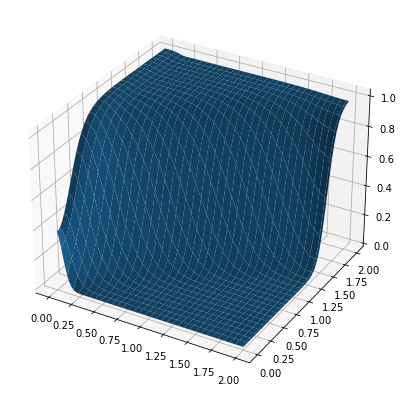

In [9]:
X, T = np.meshgrid(x, t, indexing='ij')

# plot surface
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, T, u)#, cmap=cm.coolwarm, alpha=1)

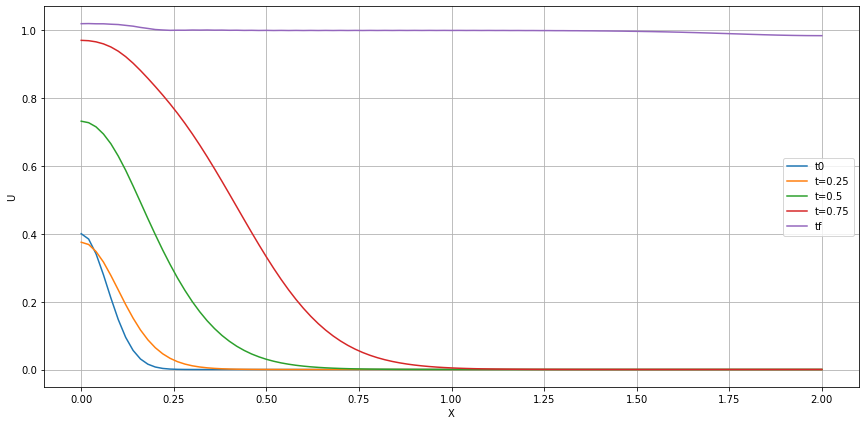

In [10]:
# plot in time
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x', 'o', 's', 'd', '^']
plt.figure(figsize=(14.6,7))

plt.plot(x, u[:,0], '-', c=colors[0])
plt.plot(x, u[:,2], '-', c=colors[1])
plt.plot(x, u[:,9], '-', c=colors[2])
plt.plot(x, u[:,16], '-', c=colors[3])
plt.plot(x, u[:,-1], '-', c=colors[4])

plt.xlabel('X')
plt.ylabel('U')
plt.legend(['t0', 't=0.25', 't=0.5', 't=0.75','tf'])
plt.grid()
plt.show()

In [11]:
noise_level = 0.01
u_noise = u + noise_level*np.abs(u)*np.random.normal(size=u.shape)

data = {}
data['u_true'] = u
data['u_noise'] = u_noise
data['D_params'] = Ds
data['K'] = K
data['rho_params'] = rhoS
data['pdf'] = pdf_vec
data['x'] = x
data['t'] = t
data['pdf_mesh']= pdf_mesh
data['phi0'] = phi0
data['noise_level'] = noise_level

np.save('NPY_Data/data_wider_3P_E2.npy',data)

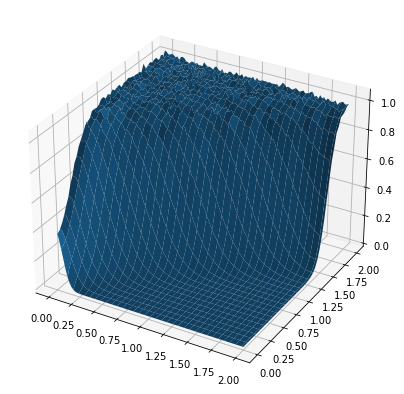

In [12]:
X, T = np.meshgrid(x, t, indexing='ij')

# plot surface
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, T, u_noise)#, cmap=cm.coolwarm, alpha=1)

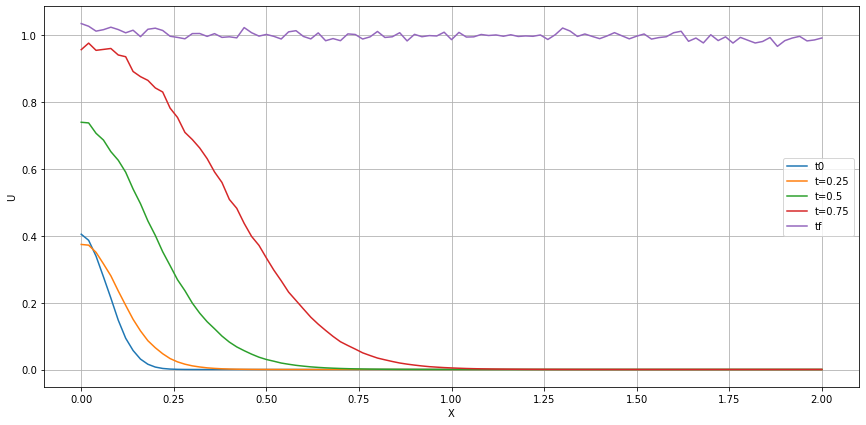

In [13]:
# plot in time
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x', 'o', 's', 'd', '^']
plt.figure(figsize=(14.6,7))

plt.plot(x, u_noise[:,0], '-', c=colors[0])
plt.plot(x, u_noise[:,2], '-', c=colors[1])
plt.plot(x, u_noise[:,9], '-', c=colors[2])
plt.plot(x, u_noise[:,16], '-', c=colors[3])
plt.plot(x, u_noise[:,-1], '-', c=colors[4])

plt.xlabel('X')
plt.ylabel('U')
plt.legend(['t0', 't=0.25', 't=0.5', 't=0.75','tf'])
plt.grid()
plt.show()